In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


sin(5x)*e^-x^2

In [17]:
# Define the symbolic function
def symbolic_function(x):
    return np.sin(5 * x) * np.exp(-x**2)

# Generate input data
np.random.seed(0)
x_values = np.linspace(-2, 2, 1000)
np.random.shuffle(x_values)
x_train = x_values[:800]
x_test = x_values[800:]

# Generate output data
y_train = symbolic_function(x_train)
y_test = symbolic_function(x_test)

# Convert to PyTorch tensors and reshape
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)


In [18]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [19]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),  # You can experiment with other activation functions
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.model(x)


In [20]:
class BSplineActivation(nn.Module):
    def __init__(self, num_parameters=10, init_range=(-1, 1)):
        super(BSplineActivation, self).__init__()
        # Initialize control points
        self.control_points = nn.Parameter(torch.linspace(init_range[0], init_range[1], num_parameters))
        # Initialize weights
        self.weights = nn.Parameter(torch.randn(num_parameters))
    
    def forward(self, x):
        # Apply the B-spline approximation
        # For simplicity, we'll use linear interpolation between control points
        x_clipped = torch.clamp(x, self.control_points[0].item(), self.control_points[-1].item())
        indices = torch.bucketize(x_clipped, self.control_points)
        indices = torch.clamp(indices, 1, len(self.control_points)-1)
        
        x0 = self.control_points[indices - 1]
        x1 = self.control_points[indices]
        y0 = self.weights[indices - 1]
        y1 = self.weights[indices]
        
        slope = (y1 - y0) / (x1 - x0 + 1e-6)
        output = y0 + slope * (x_clipped - x0)
        return output


In [21]:
class KAN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1, num_spline_points=10):
        super(KAN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act1 = BSplineActivation(num_parameters=num_spline_points)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = BSplineActivation(num_parameters=num_spline_points)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x


In [22]:
def train_model(model, optimizer, criterion, train_loader, num_epochs=500):
    model.train()
    train_losses = []
    for epoch in tqdm(range(num_epochs), desc='Training'):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
    return train_losses

def evaluate_model(model, criterion, test_loader):
    model.eval()
    test_loss = 0.0
    preds = []
    trues = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
    test_loss = test_loss / len(test_loader.dataset)
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return test_loss, preds, trues


In [23]:
mlp_model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

print("Training MLP Model")
mlp_train_losses = train_model(mlp_model, optimizer, criterion, train_loader)
mlp_test_loss, mlp_preds, mlp_trues = evaluate_model(mlp_model, criterion, test_loader)
print(f"MLP Test MSE Loss: {mlp_test_loss:.6f}")


Training MLP Model


Training: 100%|██████████| 500/500 [00:09<00:00, 55.16it/s]

MLP Test MSE Loss: 0.000017


In [24]:
kan_model = KAN(num_spline_points=20).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(kan_model.parameters(), lr=0.01)

print("Training KAN Model")
kan_train_losses = train_model(kan_model, optimizer, criterion, train_loader)
kan_test_loss, kan_preds, kan_trues = evaluate_model(kan_model, criterion, test_loader)
print(f"KAN Test MSE Loss: {kan_test_loss:.6f}")


Training KAN Model


Training: 100%|██████████| 500/500 [00:15<00:00, 31.89it/s]

KAN Test MSE Loss: 0.000002


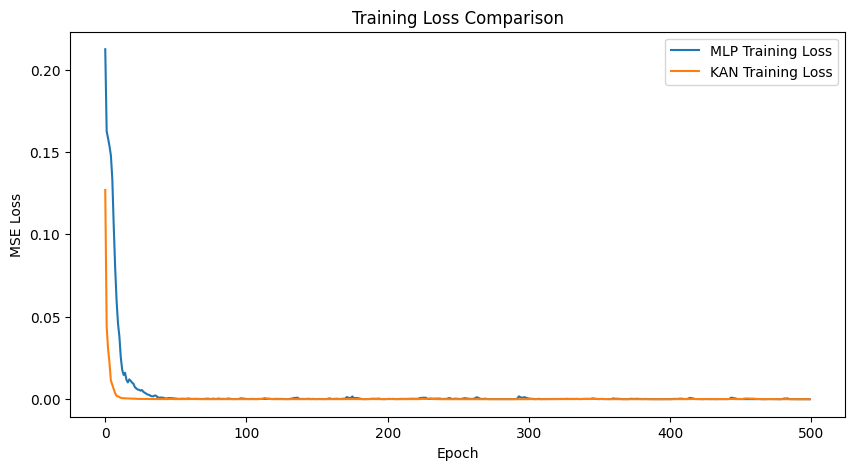

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(mlp_train_losses, label='MLP Training Loss')
plt.plot(kan_train_losses, label='KAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()


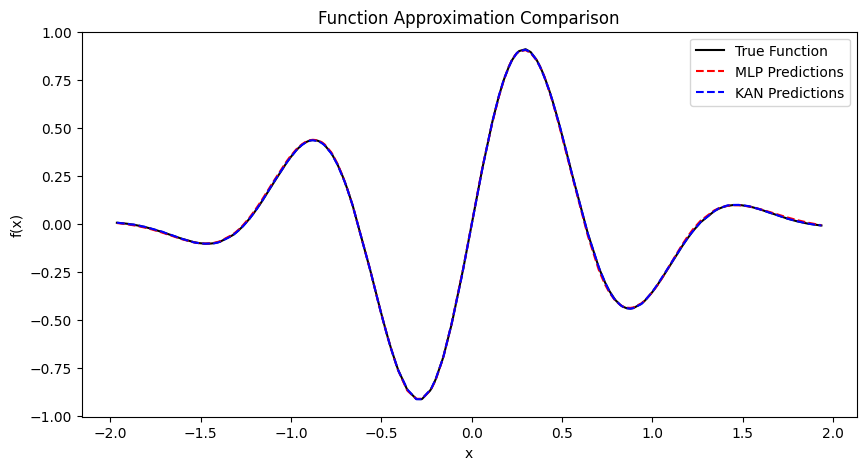

In [26]:
plt.figure(figsize=(10, 5))

# Sort test data for plotting
sorted_indices = np.argsort(x_test)
x_test_sorted = x_test[sorted_indices]
mlp_preds_sorted = mlp_preds[sorted_indices]
kan_preds_sorted = kan_preds[sorted_indices]
y_test_sorted = y_test[sorted_indices]

plt.plot(x_test_sorted, y_test_sorted, 'k-', label='True Function')
plt.plot(x_test_sorted, mlp_preds_sorted, 'r--', label='MLP Predictions')
plt.plot(x_test_sorted, kan_preds_sorted, 'b--', label='KAN Predictions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function Approximation Comparison')
plt.legend()
plt.show()
